# Context

**Input**:

NetworkX Directed Graph data

**Output**:

Standardized swc files (www.neuromorpho.org)

[SWC specification](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html)

# To Do:
[ ] Filtering the data out of redudant nodes

[ ] Add soma section* from graph[soma_shell]

*see [soma docs](https://docs.arbor-sim.org/en/stable/fileformat/swc.html)

In [1]:
import visualization as vis
import pickle
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.io import ascii
from astropy.table import Table

In [27]:
# filename = '3wk-both1-grn-raw.pic-sequential_graph.pickle'
# data = pd.read_pickle(filename)

In [4]:
# graph stuff
def get_tips(g):
    return {n for n in g.nodes if len(list(g.successors(n))) == 0}
            
def get_roots(g):
    return {n for n in g.nodes if len(list(g.predecessors(n))) < 1}

def get_branch_points(g):
    return {n for n in g.nodes if len(list(g.successors(n))) > 1}       

# Note: neighbors() == successors() 

In [5]:
r = get_roots(data)
t = get_tips(data)
b = get_branch_points(data)

data_paths = vis.graph_to_paths(data)
print(f'Keys:{data_paths.keys()}', '\n',  f'\nRoots: {r}')


NameError: name 'data' is not defined

In [61]:
root = data_paths[(38, 202, 203)]

In [671]:
#We've got 7 times increased detalization than usual SWC contain
range(len(data))

range(0, 6911)

In [672]:
list(data.nodes.data())[0]

((39, 145, 130),
 {'root': (37, 206, 180),
  'occurence': 6.860663671448287,
  'sigma_mask': 5.656854249492381,
  'sigma_opt': 4.0})

In [624]:
list(data.edges.data())[0]

((39, 145, 130), (39, 144, 129), {'weight': 1})

In [625]:
list(data.nodes.data('root'))

[((39, 145, 130), (37, 206, 180)),
 ((37, 203, 215), (38, 202, 203)),
 ((26, 257, 235), (35, 246, 203)),
 ((45, 153, 148), (37, 206, 180)),
 ((31, 202, 92), (36, 211, 176)),
 ((48, 188, 251), (39, 198, 198)),
 ((27, 258, 204), (34, 246, 199)),
 ((30, 247, 131), (36, 212, 176)),
 ((37, 181, 89), (36, 211, 176)),
 ((44, 166, 154), (37, 206, 180)),
 ((28, 192, 140), (36, 211, 176)),
 ((37, 285, 146), (36, 248, 178)),
 ((35, 195, 259), (38, 202, 203)),
 ((44, 121, 88), (37, 206, 180)),
 ((28, 245, 151), (36, 212, 176)),
 ((27, 197, 86), (36, 211, 176)),
 ((33, 179, 115), (36, 211, 176)),
 ((39, 148, 148), (37, 206, 180)),
 ((43, 113, 95), (37, 206, 180)),
 ((47, 108, 150), (39, 198, 198)),
 ((34, 171, 79), (36, 211, 176)),
 ((45, 229, 156), (40, 223, 178)),
 ((29, 169, 102), (36, 211, 176)),
 ((34, 256, 123), (36, 212, 176)),
 ((30, 214, 196), (36, 206, 181)),
 ((36, 291, 172), (36, 248, 178)),
 ((32, 223, 218), (35, 216, 202)),
 ((30, 290, 191), (35, 246, 203)),
 ((31, 266, 211), (35, 246

In [62]:
import random
node = random.choice(list(data.nodes()))
node

(32, 68, 194)

In [63]:
def find_root(node, graph, steps=0):
    parent = list(graph.predecessors(node))
    
    if not parent:
            return list(node), f'Steps = {steps}'
    
    else: 
        steps += 1
        for i in parent:
            return find_root(i, graph, steps)


In [628]:
list(find_root((27, 272, 204), data))

[[35, 246, 203], 'Steps = 30']

In [629]:
root = nx.get_node_attributes(data, "root")
root[(27, 272, 204)]

(35, 246, 203)

In [630]:
coords = [i[0] for i in data.nodes.data()]
all_roots = [i[1]["root"] for i in data.nodes.data()]

In [631]:
mask = (np.array(all_roots)[:,0]==40) & (np.array(all_roots)[:,1]==223) & (np.array(all_roots)[:,2]==178)
new_root = np.array(coords)[mask]
new_root = [tuple(i) for i in new_root]


In [632]:
mask

array([False, False, False, ..., False, False, False])

In [633]:
adj = nx.adjacency_matrix(data).todense()


/tmp/ipykernel_7510/3306571992.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(data).todense()


# Actual code

In [6]:

def related_tips(graph, root):
    
    # collect tree nodes
    coords = [i[0] for i in graph.nodes.data()]
    all_roots = [i[1]["root"] for i in graph.nodes.data()]
    
    #create root-specialized mask
    x, y, z = root
    root_mask = (np.array(all_roots)[:,0]==x) & (np.array(all_roots)[:,1]==y) & (np.array(all_roots)[:,2]==z)
    root_nodes = [tuple(i) for i in np.array(coords)[root_mask]]
    
    #get all tips
    my_tips = np.array(list(get_tips(graph)))
    
    #filter tips
    root_tips = []

    for tip in my_tips:
        tip = tuple(tip)
        
        if tip in root_nodes:
            root_tips.append(tip)
            
    return root_tips
        

In [7]:

len(related_tips(data, (35, 246, 203)))

NameError: name 'data' is not defined

In [636]:
D = {}
count = 1
r = (35, 246, 203)


In [637]:
D[r] = (0, -1)
for t in related_tips(data, r):
    for n in list(nx.shortest_path(data, source=r, target=t))[1:]:
        if n in D:
            continue
        else:
            num = count
             #parent name
            p_name = nx.predecessor(data, r, n)
            parent = D[p_name[0]][0]

            D[n] = (num, parent)
            count+=1
            

In [638]:
D

{(35, 246, 203): (0, -1),
 (35, 247, 204): (1, 0),
 (35, 248, 205): (2, 1),
 (35, 249, 206): (3, 2),
 (34, 250, 207): (4, 3),
 (34, 251, 208): (5, 4),
 (34, 252, 209): (6, 5),
 (33, 253, 210): (7, 6),
 (32, 254, 211): (8, 7),
 (31, 255, 212): (9, 8),
 (31, 256, 212): (10, 9),
 (31, 257, 212): (11, 10),
 (31, 258, 212): (12, 11),
 (31, 259, 213): (13, 12),
 (31, 260, 214): (14, 13),
 (31, 261, 215): (15, 14),
 (31, 262, 216): (16, 15),
 (31, 263, 217): (17, 16),
 (31, 264, 218): (18, 17),
 (30, 265, 219): (19, 18),
 (30, 266, 220): (20, 19),
 (29, 267, 221): (21, 20),
 (28, 268, 222): (22, 21),
 (27, 268, 223): (23, 22),
 (26, 268, 224): (24, 23),
 (26, 268, 225): (25, 24),
 (26, 268, 226): (26, 25),
 (26, 268, 227): (27, 26),
 (26, 268, 228): (28, 27),
 (26, 268, 229): (29, 28),
 (25, 267, 230): (30, 29),
 (25, 267, 229): (31, 30),
 (25, 268, 228): (32, 31),
 (25, 269, 227): (33, 32),
 (24, 270, 226): (34, 33),
 (23, 271, 225): (35, 34),
 (23, 272, 225): (36, 35),
 (23, 273, 224): (37,

In [8]:

def root_travel(graph, root):
    
    root_path = {}
    root_path[root] = (1, -1)
    count = 2
    
    tips = related_tips(graph, root)
    
    for tip in tips:
        for n in list(nx.shortest_path(graph, source=root, target=tip))[1:]:
            if n in root_path:
                continue
            
            else:
                num = count
                #parent name
                #return list with name of parent node
                p_name = nx.predecessor(graph, root, n)
                parent = root_path[p_name[0]][0]
                root_path[n] = (num, parent)
                count+=1
                
    return root_path


In [66]:
test_travel = root_travel(data, r)

TypeError: unhashable type: 'list'

In [641]:
r not in test_travel

False

In [644]:
max(test_travel.values())

(789, 788)

In [673]:
roots = get_roots(data)

In [674]:
roots = [r for r in roots]

In [676]:
rx = list((map(lambda x: x[0], roots)))
ry = list((map(lambda x: x[1], roots)))
rz = list((map(lambda x: x[2], roots)))

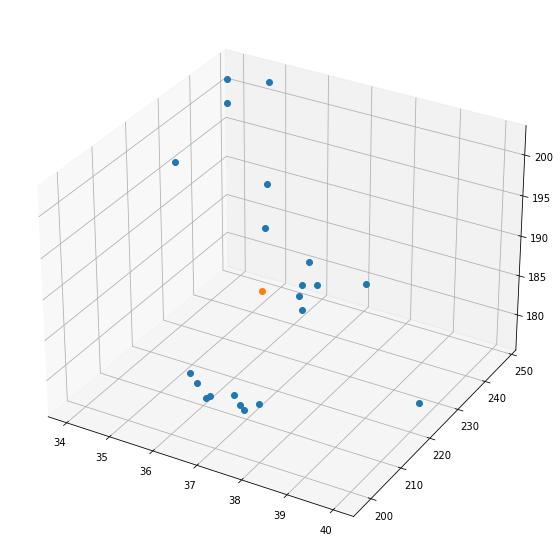

In [677]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(rx, ry, rz, 'o')
ax.plot(np.average(rx), np.average(ry), np.average(rz), 'o')

In [9]:
def roots_convergence(roots):
    roots = [r for r in roots]
    x = list((map(lambda x: x[0], roots)))
    y = list((map(lambda x: x[1], roots)))
    z = list((map(lambda x: x[2], roots)))

    return (np.average(x), np.average(y), np.average(z))


In [68]:
roots_convergence(roots)

TypeError: 'int' object is not iterable

In [24]:

def Merge_astrocyte(graph, convergence = False):
    
    roots  = get_roots(graph)
    collection = []
    
    if convergence == True:
        #connect all roots for continuous structure
        convergence = {roots_convergence(roots): (1, -1)}
        collection.append(convergence)

    
    for r in tqdm(roots):
        visit = root_travel(graph, r)
        
        #write first root 
        if not collection:
            collection.append(visit)
        
        #write subsequent roots with updated vals
        else:
            value = max(collection[-1].values())[0]
            
            for i in visit.items():
                
                #check if current node is root
                if i[0] is not r:
                    new_pos = i[1][0] + value
                    new_par = i[1][1] + value
                    visit[i[0]] = (new_pos, new_par)
                    
                else:
                    new_pos = i[1][0] + value
                    # new_par = i[1][1]
                    new_par = 1
                    visit[i[0]] = (new_pos, new_par)
                    
            collection.append(visit)
        
    return collection

In [652]:
M = Merge_astrocyte(data, convergence=True)

100%|███████████████████████████████████████████| 21/21 [00:09<00:00,  2.24it/s]


In [653]:
max(M[-1].values())

(6912, 6911)

In [656]:
dd = Table()

In [519]:
X = []
Y = []
Z = []
POS = []
PAR = []

for r in M:
    for n in r.items():
        x, y, z = n[0]
        X.append(x)
        Y.append(y)
        Z.append(z)
        pos, par = n[1]
        POS.append(pos)
        PAR.append(par)

In [520]:
dd['X'] = np.array(X)
dd['Y'] = np.array(Y)
dd['Z'] = np.array(Z)
dd['index'] = np.array(POS)
dd['parent'] = np.array(PAR)

In [521]:
dd


<Table length=6912>
   X            Y                 Z          index parent
float64      float64           float64       int64 int64 
------- ----------------- ------------------ ----- ------
   37.0 215.1904761904762 189.66666666666666     1     -1
   38.0             202.0              203.0     2      1
   38.0             201.0              204.0     3      2
   38.0             200.0              205.0     4      3
   38.0             199.0              206.0     5      4
   38.0             199.0              207.0     6      5
    ...               ...                ...   ...    ...
   40.0             202.0              267.0  6906   6905
   40.0             203.0              268.0  6907   6906
   40.0             203.0              269.0  6908   6907
   40.0             204.0              270.0  6909   6908
   41.0             198.0              234.0  6910   6874
   41.0             199.0              235.0  6911   6910
   41.0             200.0              236.0  6912   6911

*Woohoo!!!*


In [50]:
def SWC_from_Graph(graph, cell_type, filename):
    
    astro = Merge_astrocyte(graph, convergence=True)
    lines = []
    # credits = '# Created by Anya :))\n'
    keys = ['# index ', 'type ', 'X ', 'Y ', 'Z ', 'radius ', 'parent', '\n']
    ntype = cell_type
    soma = 1
    radius = 0.125
    
#     #txt version
#     with open(f'{filename}.swc', 'w') as f:
#         # f.write(credits)
#         # f.writelines(keys)
        
#         for r in astro:
#             for n in r.items():
#                 x, y, z = n[0]
#                 index, par = n[1]

#                 f.writelines([f'{index} ', f'{ntype} ',
#                               f'{x} ', f'{y} ', f'{z} ', 
#                              f'{radius} ', f'{par}', '\n'])
    
    #ascii version
    data = Table()

    X = []
    Y = []
    Z = []
    POS = []
    PAR = []

    for r in astro:
        for n in r.items():
            x, y, z = n[0]
            X.append(x)
            Y.append(y)
            Z.append(z)
            pos, par = n[1]
            POS.append(pos)
            PAR.append(par)

    data['# index'] = np.array(POS)
    data['type'] = ntype
    data['X'] = np.array(X)
    data['Y'] = np.array(Y)
    data['Z'] = np.array(Z)
    data['radius'] = radius
    data['parent'] = np.array(PAR)

    data.write(filename, format='ascii', overwrite=True) 
    

In [551]:
SWC_from_Graph(data, 7, 'Astro')

100%|███████████████████████████████████████████| 21/21 [00:08<00:00,  2.39it/s]


# Test

In [12]:
import tmd 
from tmd.view import view, plot
import morphio
import sys
import morphio 
import neurom as nm
from neurom.view import matplotlib_impl, matplotlib_utils

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [13]:
neuromorpho = '/home/anna/Documents/jupy_projects/TMD_test/Astro-10_2.CNG.swc'

In [14]:
morphology = morphio.mut.Morphology('3wk-both1-grn-raw.swc')

RawDataError: File: 3wk-both1-grn-raw.swc does not exist.

In [584]:
cell = tmd.io.load_neuron('3wk-both1-grn-raw.swc', remove_duplicates=True)

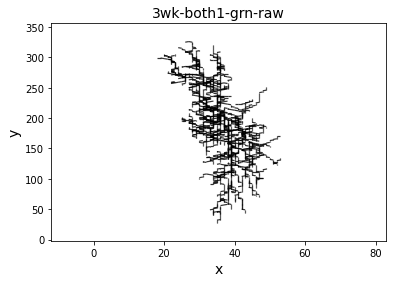

In [657]:
view.neuron(cell, nosoma=True, diameter=False)
# plt.savefig('cell.png', dpi=300)

In [658]:
ph_astro = tmd.methods.get_ph_neuron(cell)


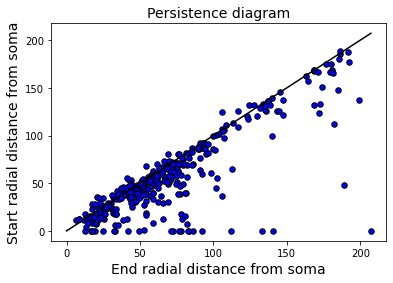

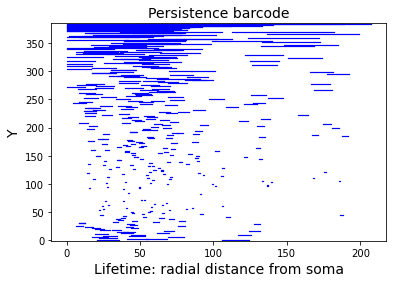

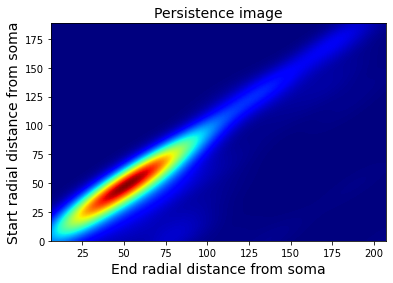

In [660]:
plot.diagram(ph_astro, subplot=True)
plt.savefig('diagram.png', dpi=300)

plot.barcode(ph_astro, subplot=True)
plt.savefig('barcode.png', dpi=300)

plot.persistence_image(ph_astro, subplot=True)
plt.savefig('persistence_image.png', dpi=300)

In [588]:
m = nm.io.utils.load_morphology('3wk-both1-grn-raw.swc')
m

Morphology <soma: SomaSinglePoint(array([[3.80e+01, 2.02e+02, 2.03e+02, 1.25e-01]], dtype=float32)) <center: [ 38. 202. 203.], radius: 0.125>, n_neurites: 22>

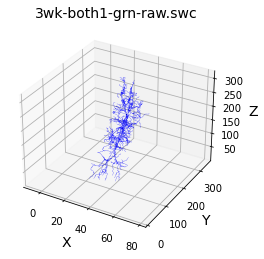

In [661]:

matplotlib_impl.plot_morph3d(m, color='blue')
plt.savefig('cell3d.png', dpi=300)


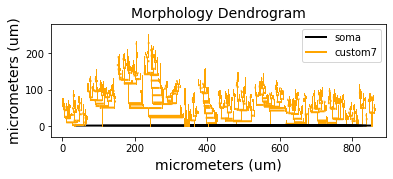

In [612]:
fig, ax = matplotlib_utils.get_figure()
matplotlib_impl.plot_dendrogram(m, ax)
matplotlib_utils.plot_style(fig=fig, ax=ax)

# Convert them all!

In [ ]:
convert = False

In [15]:
import glob
filepath = '/home/anna/Documents/astrocyte-graphs/*.pickle'

In [15]:
# def dat_inf(paths):
    
#     graphs = {}
#     t = []
#     r = []
#     n = []
#     p = []

#     for path in glob.glob(filepath):
#         name = path.split('/')[-1].split('.')[0]
#         dat = pd.read_pickle(path)
#         tips = len(get_tips(dat))
#         roots = len(get_roots(dat))
#         nodes = len(get_branch_points(dat))
#         t.append(tips)
#         r.append(roots)
#         n.append(nodes)
#         p.append(path)
#         graphs[name] = [path, dat]
    
#     k = list(graphs.keys())
#     table = Table()
#     table['name'] = k
#     table['tips'] = t
#     table['roots'] = r
#     table['nodes'] = n
#     table['path'] = p
#     return table

In [16]:
# DF = dat_inf(filepath)

In [35]:
DATA = {}


for path in glob.glob(filepath):
    name = path.split('/')[-1].split('.')[0]
    d = pd.read_pickle(path)
    DATA[name] = d

In [36]:
k = list(DATA.keys())

In [1]:
if convert == True:
    for key in k:
        filename = '/home/anna/Documents/jupy_projects/Skeletonization/astro_swc/{}.swc'.format(key)
        SWC_from_Graph(DATA[key], 7, filename)

NameError: name 'convert' is not defined